Notes:
- Extend embedding to linear readout

# NEU-Regression: Simulation Experiments
---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

# Generate Training Data

In [115]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


When generating data...you may use one of the following options:
- For evaluating non-localy patterns: "nonlocality"
- For evaluating model performance when faced with non-stationary osculatory behaviour: "oscilatory"
- For evaluating jump-type performance when faced with a discontinuity: "jumpdiscontinuity"
- For fun: "the_nightmare"

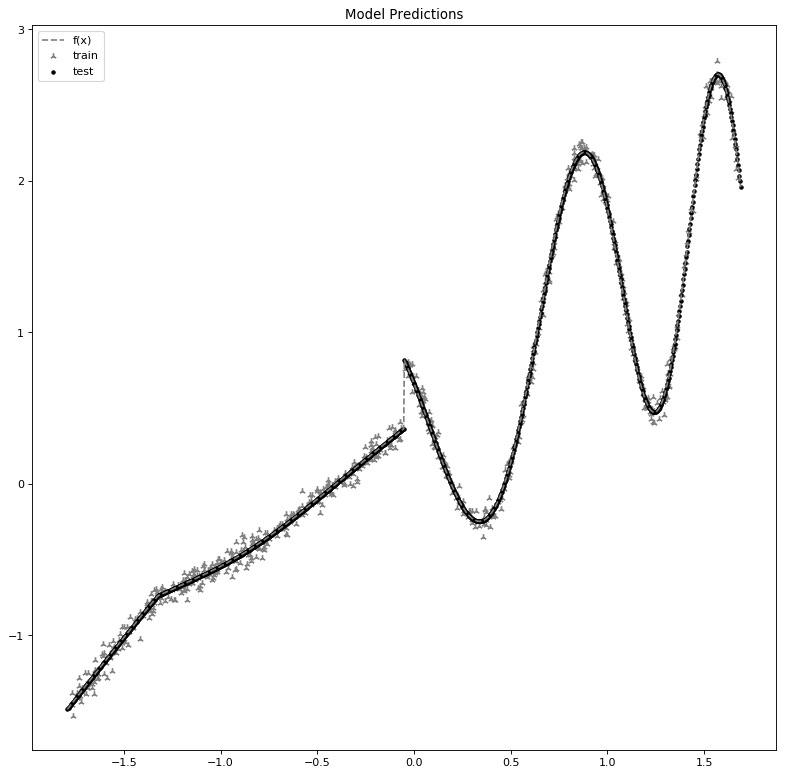

Simulation Confiugration Information:
 
We're plotting the function: the_nightmare with 0.05 additive noise, a distortion/model uncertainty level of0, and an out-of sample window on either side of the input space of:0.01.  We train using 1000 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


In [116]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
Option_Function = "the_nightmare"
# %run Data_Generator.ipynb
exec(open('Data_Generator.py').read())

**TEMP:**

Data Driven Robustness Rule:
Using [this article](https://www.sciencedirect.com/science/article/pii/S0378375815000403) for the variance estimate.  
$$
\hat{\sigma}^2 \triangleq
\frac1{(n-1)}\sum_{1<n\leq N} (y_n - y_{n-1})^2
.
$$

We couple it to the problem via the following
$$
\underset{\underset{0\leq w_n\leq 1}{\sum_{n\leq N} w_n=1}}{\operatorname{argmax}} \sum_{n\leq N} w_n L(f(x_n),\hat{f}(x_n),x_n) - \sigma^2 \sum_{n\leq N} w_n \ln\left(\frac{w_n}{N}\right)
.
$$

In [117]:
# GET STATISTICAL VARIANCE ESTIMATE
var_estimate = np.sum(np.diff(data_y)**2)/(((data_y.shape[0])-1))
var_estimate = np.float(round(var_estimate,3))

robustness_dictionary = {'robustness_parameter': [var_estimate,var_estimate*2,var_estimate*3]}
#==================================================================================#        
### Create NEU parameter disctionary by parameters joining model it is upgrading ###
#==================================================================================#
param_grid_Vanilla_Nets = {**Training_dictionary,
                       **Vanilla_ffNN_dictionary,
                       **Epochs_dictionary}

param_grid_NEU_Nets = {**Training_dictionary,
                       **robustness_dictionary,
                       **Vanilla_ffNN_dictionary,
                       **param_grid_NEU_readout_extra_parameters,
                       **param_grid_NEU_feature_extra_parameters,
                       **NEU_Epochs_Feature_dictionary}

param_grid_NEU_Feature_Only_Nets = {**Training_dictionary,
                                    **robustness_dictionary,
                                    **param_grid_NEU_feature_extra_parameters,
                                    **NEU_Epochs_Feature_dictionary}

NEU_Structure_Dictionary = {**Training_dictionary,
                            **robustness_dictionary,
                            **param_grid_NEU_readout_extra_parameters,
                            **NEU_Epochs_dictionary}

# Benchmark Models

Run univariate regression benchmarks file:

In [118]:
# %run Univariate_Regression_Benchmark_Models.ipynb
exec(open('Univariate_Regression_Benchmark_Models.py').read())

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0334s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.1388s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.2s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    3.9s finished


Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 0.6119 - mse: 0.7079 - mae: 0.6119 - mape: 121.5335
Epoch 2/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3714 - mse: 0.2772 - mae: 0.3714 - mape: 150.9959
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3505 - mse: 0.2552 - mae: 0.3505 - mape: 123.7154
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3472 - mse: 0.2525 - mae: 0.3472 - mape: 120.2322
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3470 - mse: 0.2497 - mae: 0.3470 - mape: 121.7128
Epoch 6/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3468 - mse: 0.2596 - mae: 0.3468 - mape: 131.8529
Epoch 7/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3506 - mse: 0.2512 - mae: 0.3506 - mape: 114.3842
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 0.3476 - mse: 0.2517 - mae: 0.3476 - mape: 120.6947
Epoch 9/

## Initializations:
- Load Dependancies,
- Makes Paths if missing.

In [119]:
# Second Round Re-Initializations (Global Level) #
#================================================#
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


#### Boost input dimension if $d=1$, so that reconfigurations can be universal.

In [120]:
if False:#d<= 1:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    # Bump Dimension so Reconfiguration network properties hold
    data_x = np.concatenate([data_x,data_x],axis=1)
    data_x_test = np.concatenate([data_x_test,data_x_test],axis=1)
    d = d+1
else:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    print("Modified Input since Dimension is too low")

Modified Input since Dimension is too low


---
# Train Feature Map for "decoupled" NEU-*Model(s)*
---

We train NEU's universal linearizing feature map.

In [84]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,NEU_OLS_y_hat_train_pre.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,NEU_OLS_y_hat_test_pre.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.0s finished


Epoch 1/50
15/15 [==============================] - 0s 7ms/step - loss: 0.7626 - mse: 0.5333 - mae: 0.4993 - mape: 184.3671
Epoch 2/50
15/15 [==============================] - 0s 7ms/step - loss: 0.3660 - mse: 0.2551 - mae: 0.3520 - mape: 187.7415
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3621 - mse: 0.2589 - mae: 0.3581 - mape: 189.0953
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3550 - mse: 0.2535 - mae: 0.3528 - mape: 186.6971
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.3535 - mse: 0.2536 - mae: 0.3518 - mape: 189.7338
Epoch 6/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3565 - mse: 0.2580 - mae: 0.3547 - mape: 210.2227
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3611 - mse: 0.2660 - mae: 0.3588 - mape: 186.4764
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3507 - mse: 0.2492 - mae: 0.3489 - mape: 191.6085
Epoch 9/

---
# Linear Model(s)
---

### NEU-Linear *(decoupled implementation)*

In [89]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
#====================================#
# Ordinary Linear Regression Version #
#====================================#
# NEU_lin_reg = LinearRegression()
# NEU_lin_reg.fit(data_x_featured_train,data_y)

#=====================#
# Elastic Net Version #
#=====================#
# Block warnings that spam when performing coordinate descent (by default) in 1-d.
import warnings
warnings.filterwarnings("ignore")
# Initialize Elastic Net Regularization Model
if trial_run == True: # Fast version for trial
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),5),
                               l1_ratio = np.linspace(0,1,5))
else: #Slow Version for real-deal
    NEU_lin_reg = ElasticNetCV(cv=5, 
                               random_state=0, 
                               alphas = np.linspace(0,(10**2),(10**2)),
                               l1_ratio=np.linspace(0,1,(10**2)))
# Fit Elastic Net Model
NEU_lin_reg.fit(data_x_featured_train,data_y)

ElasticNetCV(alphas=array([  0.,  25.,  50.,  75., 100.]), copy_X=True, cv=5,
             eps=0.001, fit_intercept=True,
             l1_ratio=array([0.  , 0.25, 0.5 , 0.75, 1.  ]), max_iter=1000,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [90]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


In [91]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_OLS_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_OLS_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
# ========================#
NEU_OLS_y_hat_train, NEU_OLS_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   16.9s finished


Epoch 1/50
15/15 [==============================] - 0s 12ms/step - loss: 0.7424 - mse: 1.1087 - mae: 0.7424 - mape: 147.3070
Epoch 2/50
15/15 [==============================] - 0s 13ms/step - loss: 0.8140 - mse: 1.2051 - mae: 0.8140 - mape: 219.5128
Epoch 3/50
15/15 [==============================] - 0s 13ms/step - loss: 0.8409 - mse: 1.2763 - mae: 0.8409 - mape: 204.8577
Epoch 4/50
15/15 [==============================] - 0s 13ms/step - loss: 0.7888 - mse: 1.2622 - mae: 0.7888 - mape: 175.1815
Epoch 5/50
15/15 [==============================] - 0s 12ms/step - loss: 0.6476 - mse: 0.8177 - mae: 0.6476 - mape: 178.0411
Epoch 6/50
15/15 [==============================] - 0s 11ms/step - loss: 0.4968 - mse: 0.4303 - mae: 0.4968 - mape: 241.5804
Epoch 7/50
15/15 [==============================] - 0s 12ms/step - loss: 0.4922 - mse: 0.4414 - mae: 0.4922 - mape: 223.6757
Epoch 8/50
15/15 [==============================] - 0s 12ms/step - loss: 0.3685 - mse: 0.2650 - mae: 0.3685 - mape: 188.5293


#### Visual Comaprison between the OLS and the NEU-OLS models:

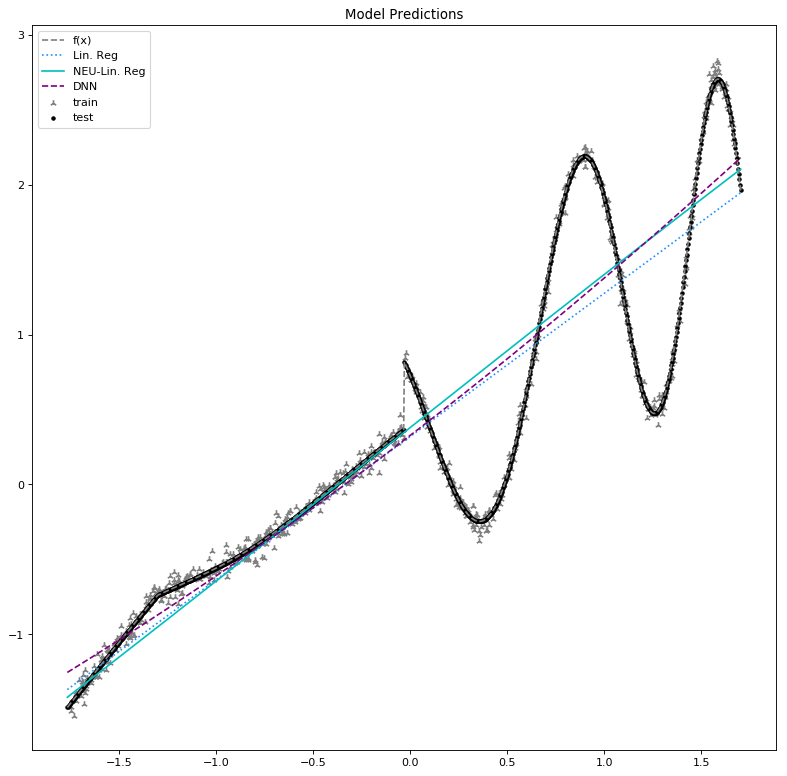

In [92]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')

# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU-Lin. Reg')
# plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test_pre, color = 'red',label='NEU-Lin. Reg - Feature Only')
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'purple',linestyle="--",  label='DNN')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

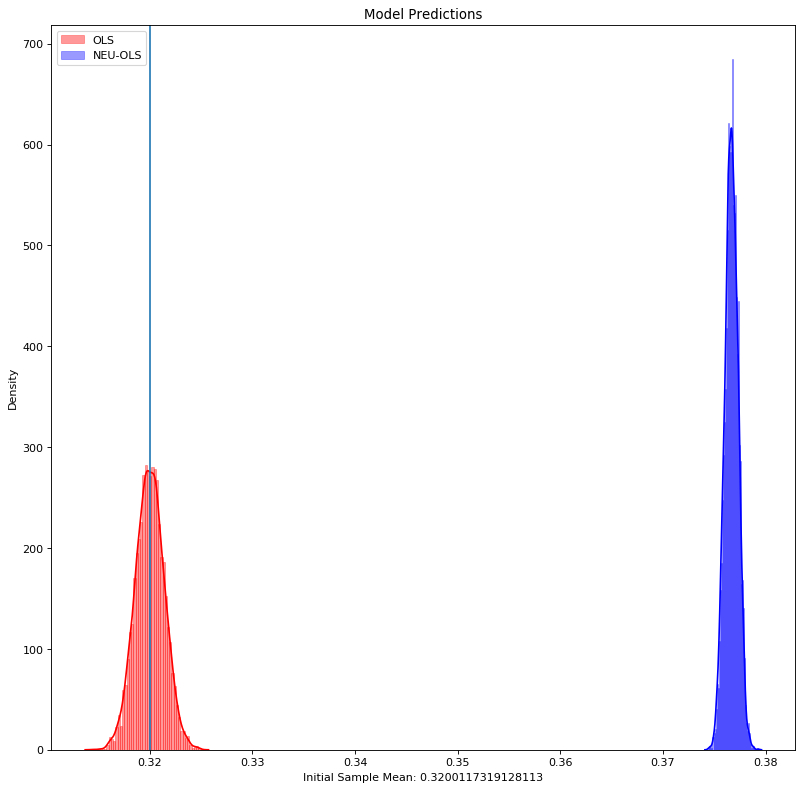

In [93]:
get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test,"OLS")

#### Comparison between Elastic-Net and NEU-ENET

In [94]:
#-----------------#
# Linear Model(s) #
#-----------------#
# Elastic-Net Performance
print("Elastic-Net Performance:")
print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test))

# NEU-Elastic Net Performance
print("NEU-ENET Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

# ffNN
print("Benchmark: DNN (ffNN)")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

Elastic-Net Performance:
                 Train       Test
Er. 95L  -3.582911e-02  -0.026886
Er. Mean -9.473903e-18   0.001854
Er. 95U   3.608225e-02   0.031567
MAE       3.522399e-01   0.331775
MSE       2.450271e-01   0.226120
MAPE      4.638053e+02  54.749169
NEU-ENET Performance:
              Train       Test
Er. 95L   -0.094353  -0.084430
Er. Mean  -0.058520  -0.054773
Er. 95U   -0.022834  -0.025348
MAE        0.354464   0.329846
MSE        0.253712   0.235220
MAPE      45.577037  41.857660
Benchmark: DNN (ffNN)
              Train       Test
Er. 95L   -0.098229  -0.089381
Er. Mean  -0.063333  -0.060668
Er. 95U   -0.028109  -0.031867
MAE        0.344727   0.324799
MSE        0.242087   0.226540
MAPE      70.824020  52.664864


---
# Non-Linear Models
---

### NEU-Smoothing Splines

In [95]:
# # 2) Perform Linear Regression on Feature-Space #
# #===============================================#
# NEU_Ssplines_y_hat_train,NEU_Ssplines_y_hat_test = get_smooting_splines(data_x = (data_x_NEU_train_feature_only.mean(axis=1)),
#                                                                                        data_x_test = (data_x_NEU_test_feature_only.mean(axis=1)),
#                                                                                        data_y = data_y)

# # Pre-process Linearized Data #
# #=============================#
# # Get Linearized Predictions #
# #----------------------------#
# # Coerce data into form ready for NEU-Structure Map
# data_x_NEU_train_Ssplines = np.concatenate([data_x_raw,
#                                    NEU_Ssplines_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
# data_x_NEU_test_Ssplines = np.concatenate([data_x_test_raw,
#                                   NEU_Ssplines_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# # 3) Learn Structure Map #
# #========================#
# NEU_Ssplines_y_hat_train, NEU_Ssplines_y_hat_test = build_NEU_Readout(n_folds = CV_folds, 
#                                                                 n_jobs = n_jobs, 
#                                                                 n_iter = n_iter, 
#                                                                 param_grid_in = NEU_Structure_Dictionary, 
#                                                                 X_train = NEU_Ssplines_y_hat_train.reshape(-1,D), 
#                                                                 y_train = data_y,
#                                                                 X_test = NEU_Ssplines_y_hat_test.reshape(-1,D))

#### Visual Comaprison between the Smoothing Splines and the NEU-Smoothing Splines models:

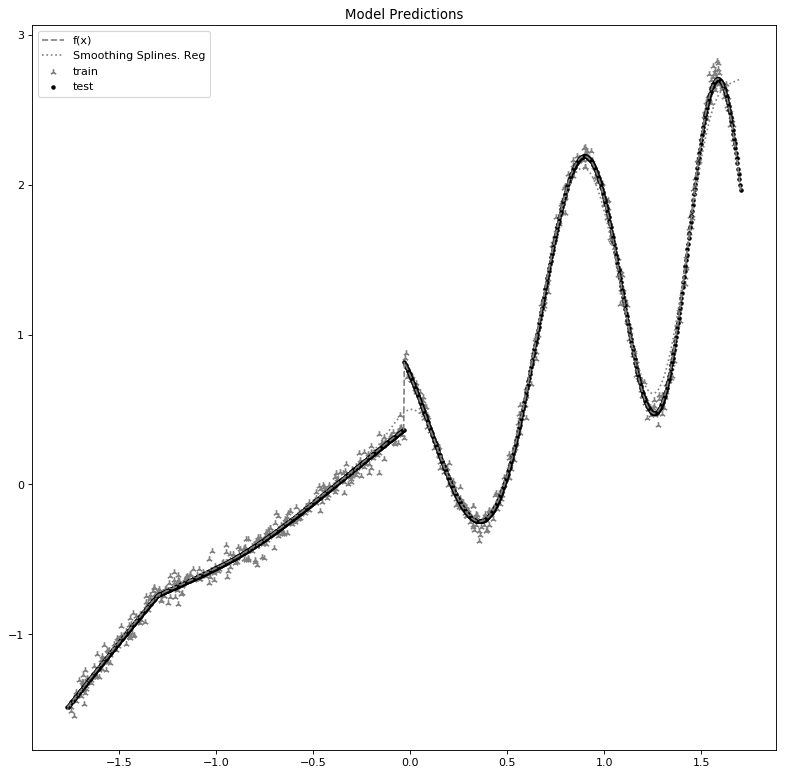

In [96]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test, color = 'grey',linestyle=":", label='Smoothing Splines. Reg')
#plt.plot(np.array(data_x_test_raw).reshape(-1,),OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# Plot NEU-OLS
# plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_Ssplines_y_hat_test, color = 'sienna',label='NEU-Smoothing Splines')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

In [97]:
# get_Error_distribution_plots(data_y_test,f_hat_smoothing_splines_test,NEU_Ssplines_y_hat_test,"Splines")

#### Numerical Comparison between the Smoothing Splines regressor and NEU-Smoothing Splines regressor models:

In [99]:
# #-----------------------#
# # Kernel Ridge Model(s) #
# #-----------------------#
# # Kernel Ridge Performance
# print("Smoothing Splines Performance:")
# print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# # NEU-Kernel Ridge Performance
# print("NEU-Smoothing Splines Performance:")
# print(reporter(NEU_Ssplines_y_hat_train,NEU_Ssplines_y_hat_test,data_y,data_y_test))

### NEU-Kernel Ridge Regression *(decoupled implementation)*

In [100]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_KReg_y_hat_train,NEU_KReg_y_hat_test, NEU_KReg_model = get_Kernel_Ridge_Regressor(data_x_in = data_x_featured_train,
                                                                                       data_x_test_in = data_x_featured_test,
                                                                                       data_y_in = data_y)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train_KReg = np.concatenate([data_x_raw,
                                   NEU_KReg_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test_KReg = np.concatenate([data_x_test_raw,
                                  NEU_KReg_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_KReg_y_hat_train, NEU_KReg_y_hat_test = build_NEU_Readout(n_folds = CV_folds, 
                                                                n_jobs = n_jobs, 
                                                                n_iter = n_iter, 
                                                                param_grid_in = NEU_Structure_Dictionary, 
                                                                X_train = NEU_KReg_y_hat_train.reshape(-1,D), 
                                                                y_train = data_y,
                                                                X_test = NEU_KReg_y_hat_test.reshape(-1,D))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0630s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.3s finished


Epoch 1/50
15/15 [==============================] - 0s 3ms/step - loss: 0.5199 - mse: 0.3688 - mae: 0.5199 - mape: 111.3027
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4646 - mse: 0.3128 - mae: 0.4646 - mape: 93.4731
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4023 - mse: 0.2358 - mae: 0.4023 - mape: 86.3424
Epoch 4/50
15/15 [==============================] - 0s 4ms/step - loss: 0.3173 - mse: 0.1593 - mae: 0.3173 - mape: 64.7285
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.2007 - mse: 0.0679 - mae: 0.2007 - mape: 49.2986
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0674 - mse: 0.0090 - mae: 0.0674 - mape: 27.3712
Epoch 7/50
15/15 [==============================] - 0s 4ms/step - loss: 0.0367 - mse: 0.0023 - mae: 0.0367 - mape: 25.4237
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0357 - mse: 0.0022 - mae: 0.0357 - mape: 23.5519
Epoch 9/50
15/1

#### Visual Comaprison between the Kernel Ridge Regression and the NEU-Kernel Ridge Regression models:

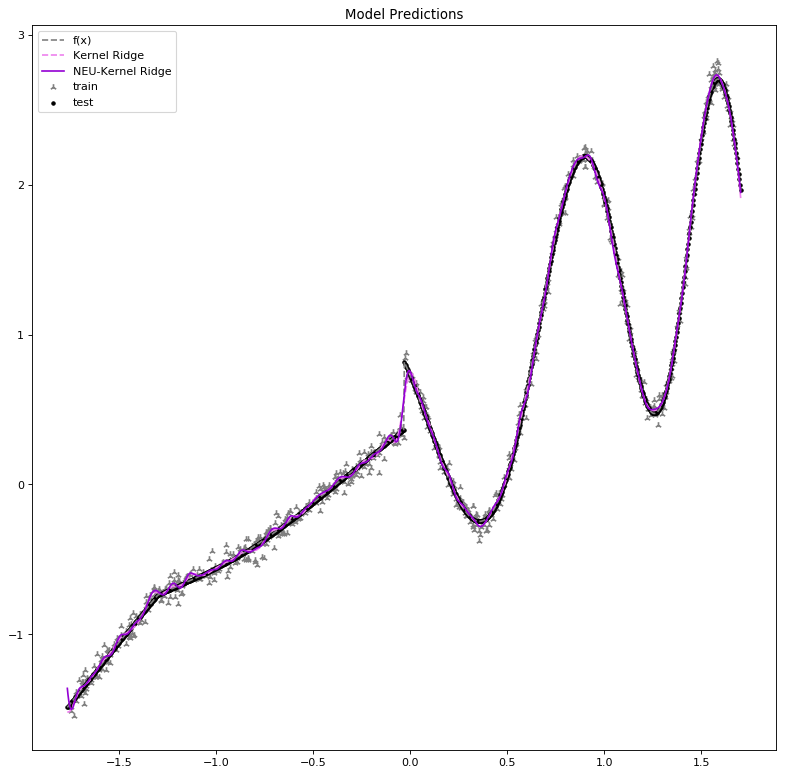

In [101]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

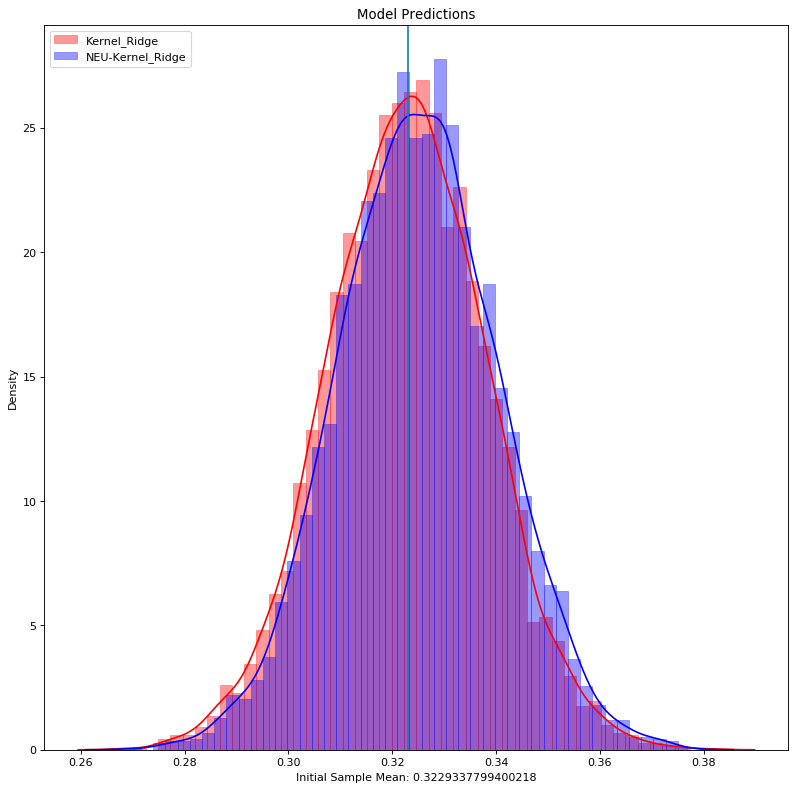

In [102]:
get_Error_distribution_plots(data_y_test,f_hat_kernel_ridge_test,NEU_KReg_y_hat_test,"Kernel_Ridge")

#### Numerical Comparison between the Kernel Ridge regressor and NEU-Kernel Ridge regressor models:

In [103]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
              Train      Test
Er. 95L   -0.003361 -0.002466
Er. Mean   0.000008 -0.001068
Er. 95U    0.003454  0.000379
MAE        0.036529  0.014616
MSE        0.002333  0.000529
MAPE      20.288634  7.217880
NEU-Kernel Ridge-Performance:
              Train      Test
Er. 95L   -0.005215 -0.004582
Er. Mean  -0.001829 -0.003117
Er. 95U    0.001456 -0.001643
MAE        0.035180  0.016738
MSE        0.002187  0.000589
MAPE      15.628461  9.526407


## Tree Model(s):
*Naturally, all of these have a decoupled implementation*.

In [104]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test, GBRF_w_NEU_features = get_GBRF(X_train = data_x_featured_train,
                                                                         X_test = data_x_featured_test,
                                                                         y_train = data_y)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
# data_x_NEU_train_GBRF = np.concatenate([data_x_featured_train,
#                                    NEU_GBRF_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
# data_x_NEU_test_GBRF = np.concatenate([data_x_featured_test,
#                                   NEU_GBRF_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
# ========================#
NEU_GBRF_y_hat_train, NEU_GBRF_y_hat_test = build_NEU_Readout(n_folds = CV_folds, 
                                                                n_jobs = n_jobs, 
                                                                n_iter = n_iter, 
                                                                param_grid_in = NEU_Structure_Dictionary, 
                                                                X_train = NEU_GBRF_y_hat_train.reshape(-1,D),
                                                                y_train = data_y,
                                                                X_test = NEU_GBRF_y_hat_test.reshape(-1,D))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.8s finished


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.3s finished


Epoch 1/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3632 - mse: 0.1796 - mae: 0.3632 - mape: 77.1929
Epoch 2/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3113 - mse: 0.1344 - mae: 0.3113 - mape: 67.3289
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.2504 - mse: 0.0896 - mae: 0.2504 - mape: 58.5384
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.1725 - mse: 0.0462 - mae: 0.1725 - mape: 40.9342
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0765 - mse: 0.0099 - mae: 0.0765 - mape: 29.2738
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0348 - mse: 0.0021 - mae: 0.0348 - mape: 21.5594
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0306 - mse: 0.0017 - mae: 0.0306 - mape: 21.5397
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.0315 - mse: 0.0018 - mae: 0.0315 - mape: 21.6668
Epoch 9/50
15/15

#### Visual Comaprison between the GBRF and the NEU-GBRF models:

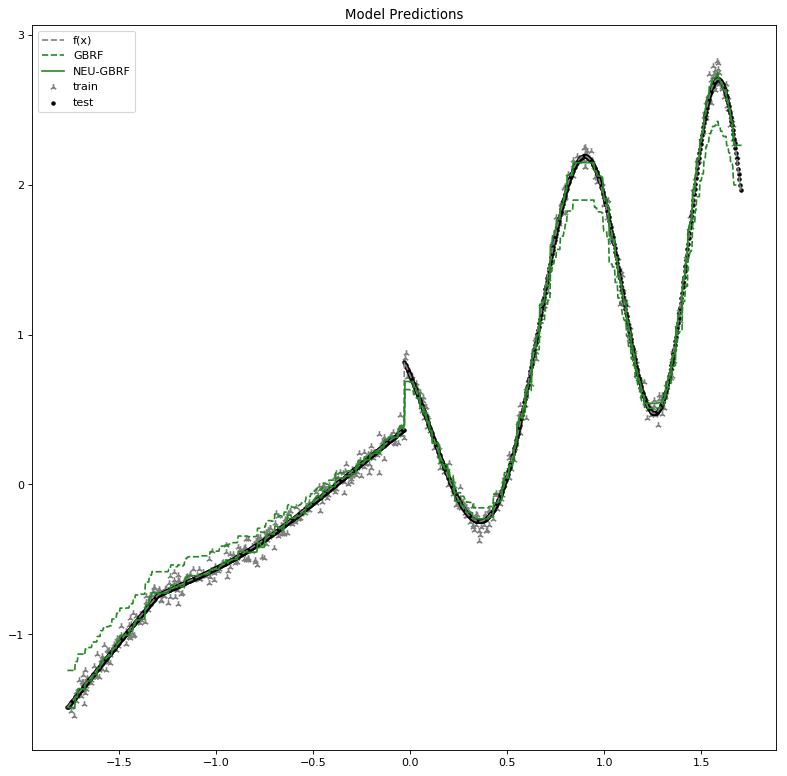

In [105]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

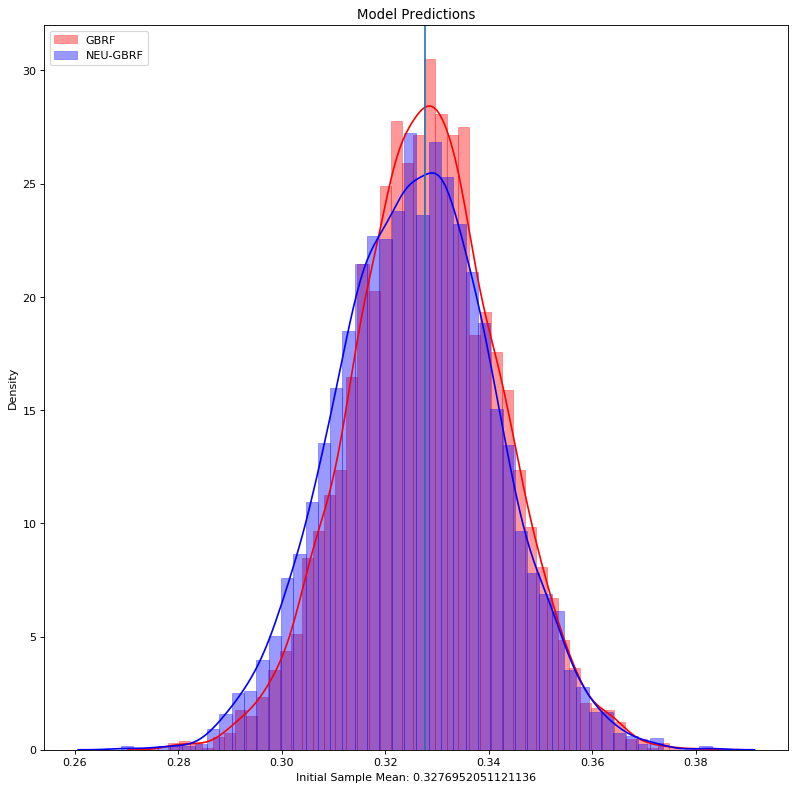

In [106]:
get_Error_distribution_plots(data_y_test,GBRF_y_hat_test,NEU_GBRF_y_hat_test,"GBRF")

#### Numerical Comparison between the GBRF and NEU-GBRF models:

In [107]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train       Test
Er. 95L  -1.062642e-02  -0.014798
Er. Mean  2.842171e-17  -0.005829
Er. 95U   1.075343e-02   0.003197
MAE       1.219672e-01   0.118478
MSE       2.268431e-02   0.020961
MAPE      1.025232e+02  61.944144
NEU-GBRF-Performance:
              Train      Test
Er. 95L   -0.004387 -0.006252
Er. Mean  -0.001525 -0.003973
Er. 95U    0.001396 -0.001581
MAE        0.029244  0.024582
MSE        0.001591  0.001426
MAPE      10.752543  7.968421


---
## Neural Networks: 
---
### NEU-ffNN

#### Fully-Coupled Implementation

#### A) $\rho\circ\hat{f}\circ \phi$

Here we only use reconfiguration networks to learn an appropriate readout map.

In [114]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   11.2s finished


Epoch 1/50
15/15 [==============================] - 0s 3ms/step - loss: 0.8227 - mse: 1.1078 - mae: 0.8190 - mape: 334.0627
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 0.4565 - mse: 0.3282 - mae: 0.4551 - mape: 359.0737
Epoch 3/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3670 - mse: 0.2862 - mae: 0.3652 - mape: 323.2605
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3653 - mse: 0.2945 - mae: 0.3633 - mape: 306.9996
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3525 - mse: 0.2636 - mae: 0.3508 - mape: 321.0491
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3254 - mse: 0.2298 - mae: 0.3239 - mape: 307.0618
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3378 - mse: 0.2569 - mae: 0.3361 - mape: 232.1177
Epoch 8/50
15/15 [==============================] - 0s 4ms/step - loss: 0.3188 - mse: 0.2239 - mae: 0.3174 - mape: 191.3005
Epoch 9/

---

**Note:** The following two models are purely out of personal curiosity and are not included in the paper.  Feel free to use them, they perform well. 

---

#### B) $\pi\circ \rho(\hat{f}\circ \phi(\cdot),\cdot)$
Here we use reconfigurations to learn an appropriate structure map. 

In [121]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train_w_proj, NEU_ffNN_y_hat_test_w_proj = build_NEU_ffNN_w_proj(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.2s finished


Epoch 1/50
15/15 [==============================] - 0s 5ms/step - loss: 0.6756 - mse: 0.9166 - mae: 0.6722 - mape: 296.8618
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.4131 - mse: 0.3257 - mae: 0.4116 - mape: 141.8051
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.4529 - mse: 0.3257 - mae: 0.4517 - mape: 149.5115
Epoch 4/50
15/15 [==============================] - 0s 6ms/step - loss: 0.3925 - mse: 0.3063 - mae: 0.3910 - mape: 130.4004
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3983 - mse: 0.3020 - mae: 0.3969 - mape: 133.6747
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3644 - mse: 0.2813 - mae: 0.3629 - mape: 120.9354
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3862 - mse: 0.3170 - mae: 0.3846 - mape: 110.1212
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 0.3450 - mse: 0.2488 - mae: 0.3437 - mape: 115.4213
Epoch 9/

#### Decoupled Implementation

In [122]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Completed Above
print("Phase 1 Complete: Feature Map Trained/Loaded")

# 2) Train ffNN #
#===============#
NEU_ffNN_y_hat_train_dcpld, NEU_ffNN_y_hat_test_dcpld = build_ffNN(n_folds = CV_folds, 
                                                                   n_jobs = n_jobs, 
                                                                   n_iter = n_iter, 
                                                                   param_grid_in = param_grid_Vanilla_Nets,  
                                                                   X_train = data_x_NEU_train_feature_only, 
                                                                   y_train = data_y,
                                                                   X_test = data_x_NEU_test_feature_only)
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
# data_x_NEU_train = np.concatenate([data_x_featured_train,
#                                    NEU_ffNN_y_hat_train_dcpld.reshape(data_x_featured_train.shape[0],D)],axis=1)
# data_x_NEU_test = np.concatenate([data_x_featured_test,
#                                   NEU_ffNN_y_hat_test_dcpld.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Update User #
#-------------#
print("Phase 2 Complete: Trained Vanilla Model")

# 3) Learn Structure Map #
#========================#
NEU_ffNN_y_hat_train_Dcpld, NEU_ffNN_y_hat_test_Dcpld = build_NEU_Readout(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = NEU_ffNN_y_hat_train_dcpld.reshape(-1,D), 
                                                           y_train = data_y,
                                                           X_test = NEU_ffNN_y_hat_test_dcpld.reshape(-1,D))

# Update User #
#-------------#
print("Phase 3 Complete: Trained NEU-Structure Map")
print("NEU Statue: Trained")

Phase 1 Complete: Feature Map Trained/Loaded
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    1.8s finished


Epoch 1/50
15/15 [==============================] - 0s 890us/step - loss: 0.8739 - mse: 1.2438 - mae: 0.8739 - mape: 122.1387
Epoch 2/50
15/15 [==============================] - 0s 1ms/step - loss: 0.8381 - mse: 1.1106 - mae: 0.8381 - mape: 164.3176
Epoch 3/50
15/15 [==============================] - 0s 1ms/step - loss: 0.7336 - mse: 0.8932 - mae: 0.7336 - mape: 158.1110
Epoch 4/50
15/15 [==============================] - 0s 1ms/step - loss: 0.5503 - mse: 0.5736 - mae: 0.5503 - mape: 126.7721
Epoch 5/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3847 - mse: 0.2867 - mae: 0.3847 - mape: 115.6678
Epoch 6/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3960 - mse: 0.2861 - mae: 0.3960 - mape: 163.8273
Epoch 7/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3605 - mse: 0.2555 - mae: 0.3605 - mape: 134.2421
Epoch 8/50
15/15 [==============================] - 0s 1ms/step - loss: 0.3564 - mse: 0.2515 - mae: 0.3564 - mape: 115.2136
Epoch 

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    6.6s finished


Epoch 1/50
15/15 [==============================] - 0s 3ms/step - loss: 0.6548 - mse: 0.7364 - mae: 0.6518 - mape: 215.3140
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 0.6046 - mse: 0.6557 - mae: 0.6017 - mape: 203.9580
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 0.5465 - mse: 0.5647 - mae: 0.5439 - mape: 186.5654
Epoch 4/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4768 - mse: 0.4701 - mae: 0.4744 - mape: 172.8174
Epoch 5/50
15/15 [==============================] - 0s 3ms/step - loss: 0.4084 - mse: 0.3688 - mae: 0.4064 - mape: 153.0015
Epoch 6/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3676 - mse: 0.2930 - mae: 0.3660 - mape: 134.3461
Epoch 7/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3509 - mse: 0.2555 - mae: 0.3496 - mape: 117.0263
Epoch 8/50
15/15 [==============================] - 0s 3ms/step - loss: 0.3508 - mse: 0.2506 - mae: 0.3496 - mape: 111.5447
Epoch 9/

## Visualization

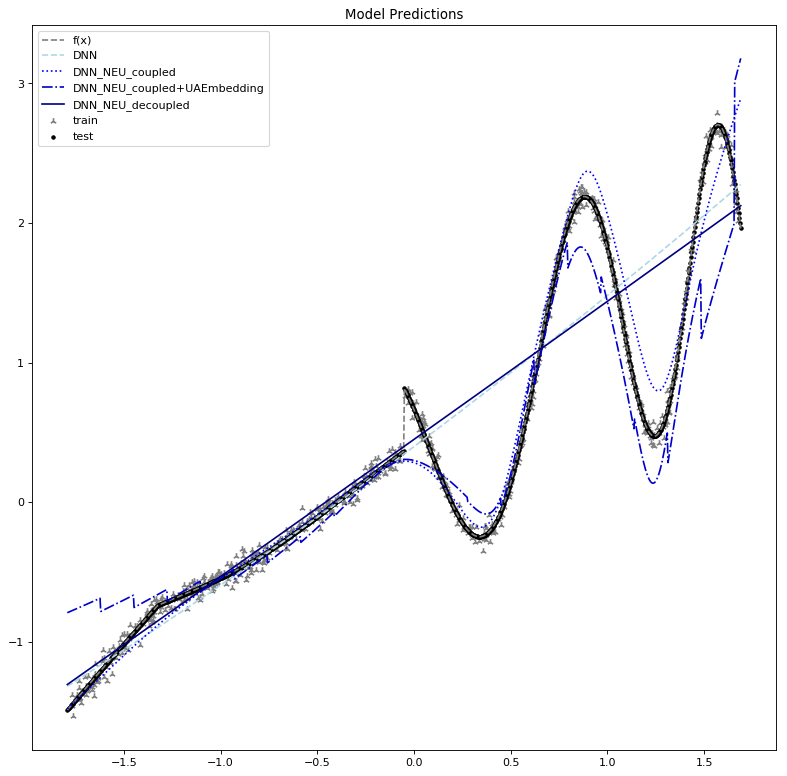

In [123]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'lightblue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'b',label='DNN_NEU_coupled')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_w_proj, color = 'mediumblue',linestyle='-.', label='DNN_NEU_coupled+UAEmbedding')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'navy',label='DNN_NEU_decoupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

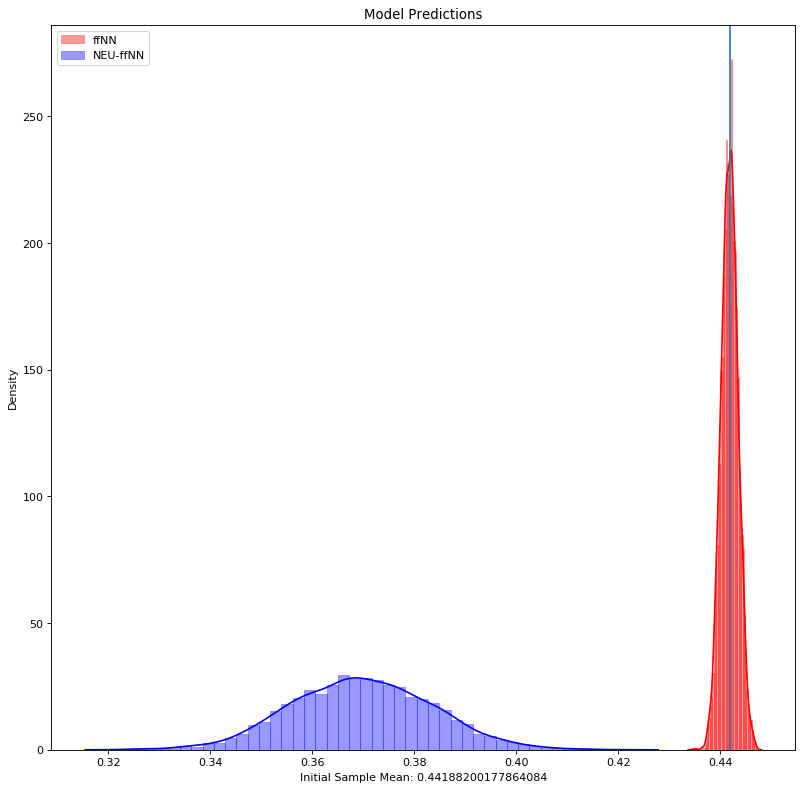

In [124]:
get_Error_distribution_plots(data_y_test,ffNN_y_hat_test,NEU_ffNN_y_hat_test,"ffNN")

---
---
---

---
# Result(s)
---

## Generate Results Table(s):

In [125]:
#==========#
# Training #
#==========#
train_performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,0],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,0],
#                                    "OLS": reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Readout-Form)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test).iloc[:,0],#}).transpose()#,
                                   "NEU-ffNN (Decoupled)": reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test).iloc[:,0]}).transpose()

train_performance.to_latex("./outputs/tables/Train_performance.tex")

#=========#
# Testing #
#=========#
test__performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,1],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,1],
#                                    "OLS": reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Readout-Form)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test).iloc[:,1],#}).transpose()#,
                                   "NEU-ffNN (Decoupled)": reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test).iloc[:,1]}).transpose()

test__performance.to_latex("./outputs/tables/Test_performance.tex")

# Visualize Predictions

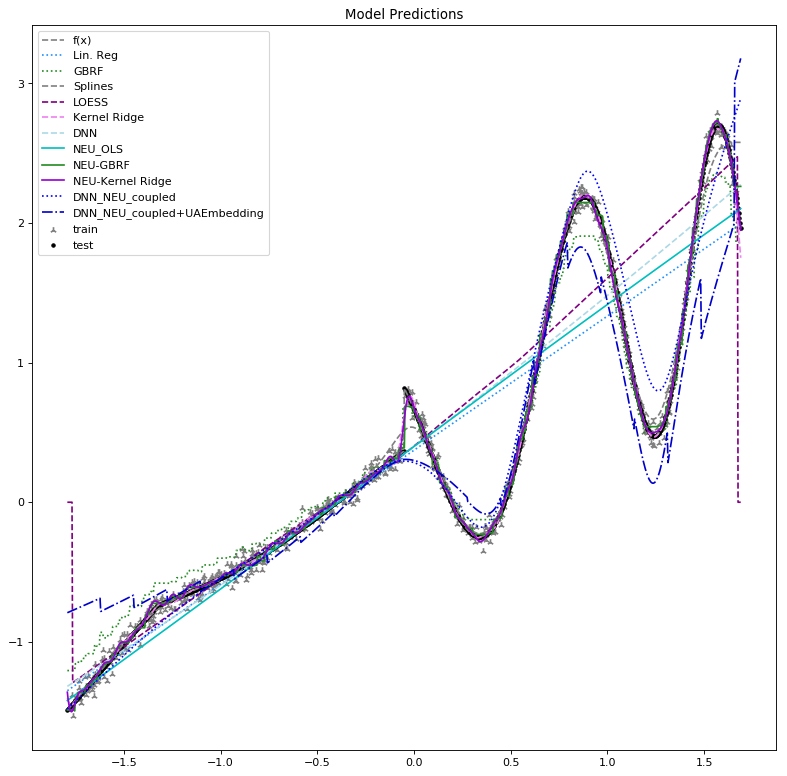

In [126]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# plt.plot(np.array(data_x_test_raw).reshape(-1,),OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='OLS')
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, color = 'forestgreen',linestyle=":", label='GBRF')
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test,color='grey',linestyle="--",label='Splines')
plt.plot(np.array(data_x_test_raw).reshape(-1,),LOESS_prediction_test,color='purple',linestyle="--",label='LOESS')
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'lightblue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'b',label='DNN_NEU_coupled')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_w_proj, color = 'mediumblue',linestyle='-.', label='DNN_NEU_coupled+UAEmbedding')
# plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'navy',label='DNN_NEU_decoupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Full_Picture.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

 ---

## Performance Report
- First, we print the comparison tables (so it can be viewed from the command-line if it is being run live on a grid/cluster/remotely).
- Second, we display the training and testing performances in clean dataframes.

In [127]:
#--------------------#
# Classical Model(s) #
#--------------------#
# OLS Performance
print("OLS-Performance:")
# print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

OLS-Performance:
NEU-OLS-Performance:
              Train       Test
Er. 95L   -0.040479  -0.084547
Er. Mean  -0.004623  -0.054773
Er. 95U    0.031473  -0.024891
MAE        0.358054   0.329846
MSE        0.251839   0.235220
MAPE      58.191113  41.857660


In [128]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
              Train      Test
Er. 95L   -0.003471 -0.002005
Er. Mean   0.000008 -0.000491
Er. 95U    0.003443  0.001090
MAE        0.038057  0.013157
MSE        0.002301  0.000625
MAPE      19.912404  7.160212
NEU-Kernel Ridge-Performance:
              Train      Test
Er. 95L    0.033012 -0.004569
Er. Mean   0.052068 -0.003117
Er. 95U    0.070756 -0.001653
MAE        0.175718  0.016738
MSE        0.073738  0.000589
MAPE      84.279085  9.526407


In [129]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train       Test
Er. 95L  -1.064147e-02  -0.021017
Er. Mean  1.894781e-17  -0.012097
Er. 95U   1.073919e-02  -0.002950
MAE       1.251503e-01   0.121411
MSE       2.285543e-02   0.021952
MAPE      6.502295e+01  82.416520
NEU-GBRF-Performance:
              Train      Test
Er. 95L    0.033236 -0.006285
Er. Mean   0.052371 -0.003973
Er. 95U    0.071447 -0.001625
MAE        0.174005  0.024582
MSE        0.073723  0.001426
MAPE      71.135835  7.968421


In [130]:
#-----------------------------------------------------#
# Classical Non-Linear Univariate Regression Model(s) #
#-----------------------------------------------------#
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

Splines-Performance:
                 Train       Test
Er. 95L  -6.379803e-03  -0.009988
Er. Mean  5.191669e-14  -0.005110
Er. 95U   6.471163e-03  -0.000349
MAE       6.254255e-02   0.040836
MSE       8.032368e-03   0.006271
MAPE      2.462836e+01  13.748287
LOESS Performance:
              Train      Test
Er. 95L   -0.173322 -0.193577
Er. Mean  -0.137030 -0.160976
Er. 95U   -0.100634 -0.128688
MAE        0.346744  0.344051
MSE        0.278048  0.299951
MAPE      40.018202       inf


In [131]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN (Coupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))
print("NEU-ffNN (Coupled+UAEmbedding) Performance:")
print(reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test))
print("NEU-ffNN (Decoupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

ffNN-Performance:
              Train       Test
Er. 95L   -0.106965  -0.129729
Er. Mean  -0.070684  -0.099455
Er. 95U   -0.035161  -0.070081
MAE        0.346905   0.322408
MSE        0.256446   0.239545
MAPE      41.571864  36.226801
NEU-ffNN (Coupled) Performance:
               Train       Test
Er. 95L     0.008204  -0.038259
Er. Mean    0.027442  -0.027093
Er. 95U     0.047394  -0.015899
MAE         0.197891   0.121939
MSE         0.074661   0.033590
MAPE      120.862775  38.089473
NEU-ffNN (Coupled+UAEmbedding) Performance:
               Train        Test
Er. 95L     0.081721    0.049875
Er. Mean    0.104811    0.071047
Er. 95U     0.128831    0.092030
MAE         0.240540    0.235701
MSE         0.120530    0.121572
MAPE      150.897857  150.110231
NEU-ffNN (Decoupled) Performance:
              Train       Test
Er. 95L   -0.096820  -0.141176
Er. Mean  -0.060720  -0.111759
Er. 95U   -0.025304  -0.082645
MAE        0.349899   0.329015
MSE        0.252646   0.239825
MAPE      84.6

# Report

## Re-Summarize Learning Problem for easy recap :)

In [132]:
print("Simulation Confiugration Information:")
print(" ")
print("=========================================================================================================================================================")
print(the_facts)
print("=========================================================================================================================================================")
print(" ")

Simulation Confiugration Information:
 
We're plotting the function: the_nightmare with 0.05 additive noise, a distortion/model uncertainty level of0, and an out-of sample window on either side of the input space of:0.01.  We train using 1000 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


## Train-Set Performance

In [133]:
train_performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.006376,5.191669e-14,0.006340,0.062543,0.008032,24.628360
LOESS,-0.174348,-1.370300e-01,-0.101273,0.346744,0.278048,40.018202
Elastic Net,-0.035264,3.789561e-17,0.035574,0.349087,0.248679,57.013510
NEU-OLS,-0.040065,-4.623232e-03,0.031124,0.358054,0.251839,58.191113
Kernel,-0.003414,7.701176e-06,0.003449,0.038057,0.002301,19.912404
NEU-KerRidge,0.032567,5.206778e-02,0.070785,0.175718,0.073738,84.279085
GBRF,-0.010884,1.894781e-17,0.010699,0.125150,0.022855,65.022950
NEU-GBRF,0.033618,5.237146e-02,0.071303,0.174005,0.073723,71.135835
ffNN,-0.107236,-7.068367e-02,-0.034823,0.346905,0.256446,41.571864
NEU-ffNN (Readout-Form),0.007589,2.744201e-02,0.047081,0.197891,0.074661,120.862775


## Test-Set Performance

In [134]:
test__performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.010002,-0.005110,-0.000339,0.040836,0.006271,13.748287
LOESS,-0.193594,-0.160976,-0.128553,0.344051,0.299951,inf
Elastic Net,-0.061702,-0.032106,-0.002762,0.321516,0.227373,42.044378
NEU-OLS,-0.084301,-0.054773,-0.025429,0.329846,0.235220,41.857660
Kernel,-0.002014,-0.000491,0.001051,0.013157,0.000625,7.160212
NEU-KerRidge,-0.004608,-0.003117,-0.001610,0.016738,0.000589,9.526407
GBRF,-0.020993,-0.012097,-0.002818,0.121411,0.021952,82.416520
NEU-GBRF,-0.006359,-0.003973,-0.001599,0.024582,0.001426,7.968421
ffNN,-0.128769,-0.099455,-0.070217,0.322408,0.239545,36.226801
NEU-ffNN (Readout-Form),-0.038296,-0.027093,-0.016074,0.121939,0.033590,38.089473


#### The END

---